# MLP for Amazon Reviews Dataset

## Importing the Data

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess data
df = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')
df = df.drop(columns=["ID"])

X = df.drop(columns=["Class"]).values.astype(np.float32)
y = df["Class"].values

In [2]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# Evaluate over different splits
split_ratios = [0.5, 0.3, 0.2, 0.1]

In [4]:
for split in split_ratios:
    print(f"\n--- Evaluating {int((1 - split) * 100)}/{int(split * 100)} Train/Test Split ---")

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=split, random_state=42,
                                                        stratify=y_encoded)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Setup model
    input_dim = X.shape[1]
    output_dim = len(np.unique(y_encoded))
    model = MLP(input_dim, output_dim)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Train model
    epochs = 200
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate model
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).argmax(dim=1).numpy()
        y_true = y_test_tensor.numpy()

        acc = accuracy_score(y_true, preds)
        prec = precision_score(y_true, preds, average='macro', zero_division=0)
        rec = recall_score(y_true, preds, average='macro', zero_division=0)
        f1 = f1_score(y_true, preds, average='macro', zero_division=0)

        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")


--- Evaluating 50/50 Train/Test Split ---
Accuracy:  0.5120
Precision: 0.6039
Recall:    0.4932
F1 Score:  0.4903

--- Evaluating 70/30 Train/Test Split ---
Accuracy:  0.5644
Precision: 0.6756
Recall:    0.5533
F1 Score:  0.5569

--- Evaluating 80/20 Train/Test Split ---
Accuracy:  0.5867
Precision: 0.6547
Recall:    0.5717
F1 Score:  0.5653

--- Evaluating 90/10 Train/Test Split ---
Accuracy:  0.6400
Precision: 0.5617
Recall:    0.6200
F1 Score:  0.5607


## Testing out different MLPs

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess data
df = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')
df = df.drop(columns=["ID"])

X = df.drop(columns=["Class"]).values.astype(np.float32)
y = df["Class"].values

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Model architectures to test
input_dim = X.shape[1]
output_dim = len(np.unique(y_encoded))
model_architectures = [
    nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, output_dim)
    ),
    nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, output_dim)
    ),
    nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, output_dim)
    ),
    nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, output_dim)
    )
]

# Store results
results = []

# Train and evaluate each model
for i, architecture in enumerate(model_architectures, 1):
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.model = architecture

        def forward(self, x):
            return self.model(x)


    model = MLP()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Train
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).argmax(dim=1).numpy()
        y_true = y_test_tensor.numpy()

        acc = accuracy_score(y_true, preds)
        prec = precision_score(y_true, preds, average='macro', zero_division=0)
        rec = recall_score(y_true, preds, average='macro', zero_division=0)
        f1 = f1_score(y_true, preds, average='macro', zero_division=0)

        results.append((f"MLP{i}", acc, prec, rec, f1))

# Print results in a table format
print("\nMODEL\tAccuracy\tPrecision\tRecall\t\tF1-Score")
for model_name, acc, prec, rec, f1 in results:
    print(f"{model_name}\t{acc:.4f}\t\t{prec:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")


MODEL	Accuracy	Precision	Recall		F1-Score
MLP1	0.4889		0.5764		0.4730		0.4691
MLP2	0.5378		0.6020		0.5293		0.5144
MLP3	0.5200		0.5755		0.5130		0.5013
MLP4	0.5689		0.6306		0.5483		0.5350


In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')

df = df.drop(columns=["ID"])

X = df.drop(columns=["Class"]).values.astype(np.float32)
y = df["Class"].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [39]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, nn_seq):
        super().__init__()
        self.model = nn_seq

    def forward(self, x):
        return self.model(x)


# Set up model, loss, and optimizer
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_encoded))

nn_seqs = [
    nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, output_dim)
    ),
    nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, output_dim)
    ),
    nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, output_dim)
    ),
]

lrs = [0.1, 0.01, 0.001, 0.0001]

epochs_l = [30, 50, 100, 200]

model = MLP(input_dim, output_dim, nn_seq=nn_seqs[1])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lrs[3], weight_decay=1e-5)

epochs = epochs_l[3]

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = torch.argmax(predictions, dim=1)
    accuracy = (predicted_classes == y_test_tensor).float().mean()
    print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 5/200, Loss: 3.6487
Epoch 10/200, Loss: 3.3179
Epoch 15/200, Loss: 2.9726
Epoch 20/200, Loss: 2.6251
Epoch 25/200, Loss: 2.2206
Epoch 30/200, Loss: 1.8511
Epoch 35/200, Loss: 1.4714
Epoch 40/200, Loss: 1.0969
Epoch 45/200, Loss: 0.8041
Epoch 50/200, Loss: 0.5575
Epoch 55/200, Loss: 0.3636
Epoch 60/200, Loss: 0.2629
Epoch 65/200, Loss: 0.1730
Epoch 70/200, Loss: 0.1298
Epoch 75/200, Loss: 0.1038
Epoch 80/200, Loss: 0.0761
Epoch 85/200, Loss: 0.0611
Epoch 90/200, Loss: 0.0530
Epoch 95/200, Loss: 0.0429
Epoch 100/200, Loss: 0.0384
Epoch 105/200, Loss: 0.0351
Epoch 110/200, Loss: 0.0328
Epoch 115/200, Loss: 0.0284
Epoch 120/200, Loss: 0.0251
Epoch 125/200, Loss: 0.0213
Epoch 130/200, Loss: 0.0221
Epoch 135/200, Loss: 0.0206
Epoch 140/200, Loss: 0.0209
Epoch 145/200, Loss: 0.0171
Epoch 150/200, Loss: 0.0180
Epoch 155/200, Loss: 0.0168
Epoch 160/200, Loss: 0.0147
Epoch 165/200, Loss: 0.0160
Epoch 170/200, Loss: 0.0138
Epoch 175/200, Loss: 0.0127
Epoch 180/200, Loss: 0.0120
Epoch 185/20

## Cross Validation
using the best model from the previous section

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess data
df = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')
df = df.drop(columns=["ID"])

X = df.drop(columns=["Class"]).values.astype(np.float32)
y = df["Class"].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model definition
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Cross-validation function
def run_cv(X, y, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    input_dim = X.shape[1]
    output_dim = len(np.unique(y))
    all_results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n[Fold {fold}/{n_splits}]")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

        model = MLP(input_dim, output_dim).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

        for epoch in range(200):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = model(X_test_tensor).argmax(dim=1).cpu().numpy()
            y_true = y_test_tensor.cpu().numpy()

            acc = accuracy_score(y_true, preds)
            prec = precision_score(y_true, preds, average='macro', zero_division=0)
            rec = recall_score(y_true, preds, average='macro', zero_division=0)
            f1 = f1_score(y_true, preds, average='macro', zero_division=0)

            all_results.append((acc, prec, rec, f1))

    return all_results

# Run both 5-fold and 10-fold CV
results_5fold = run_cv(X_scaled, y_encoded, n_splits=5)
results_10fold = run_cv(X_scaled, y_encoded, n_splits=10)

# Helper to print results
def print_results(results, label):
    accs, precs, recs, f1s = zip(*results)
    print(f"\n=== {label} Results ===")
    print("MODEL\tAccuracy\tPrecision\tRecall\t\tF1-Score")
    print(f"{label}\t{np.mean(accs):.4f}\t\t{np.mean(precs):.4f}\t\t{np.mean(recs):.4f}\t\t{np.mean(f1s):.4f}")

# Display
print_results(results_5fold, "5-Fold")
print_results(results_10fold, "10-Fold")


[Fold 1/5]

[Fold 2/5]

[Fold 3/5]

[Fold 4/5]

[Fold 5/5]

[Fold 1/10]

[Fold 2/10]

[Fold 3/10]

[Fold 4/10]

[Fold 5/10]

[Fold 6/10]

[Fold 7/10]

[Fold 8/10]

[Fold 9/10]

[Fold 10/10]

=== 5-Fold Results ===
MODEL	Accuracy	Precision	Recall		F1-Score
5-Fold	0.6280		0.6595		0.6200		0.5967

=== 10-Fold Results ===
MODEL	Accuracy	Precision	Recall		F1-Score
10-Fold	0.6613		0.5986		0.6440		0.5935


## Plots

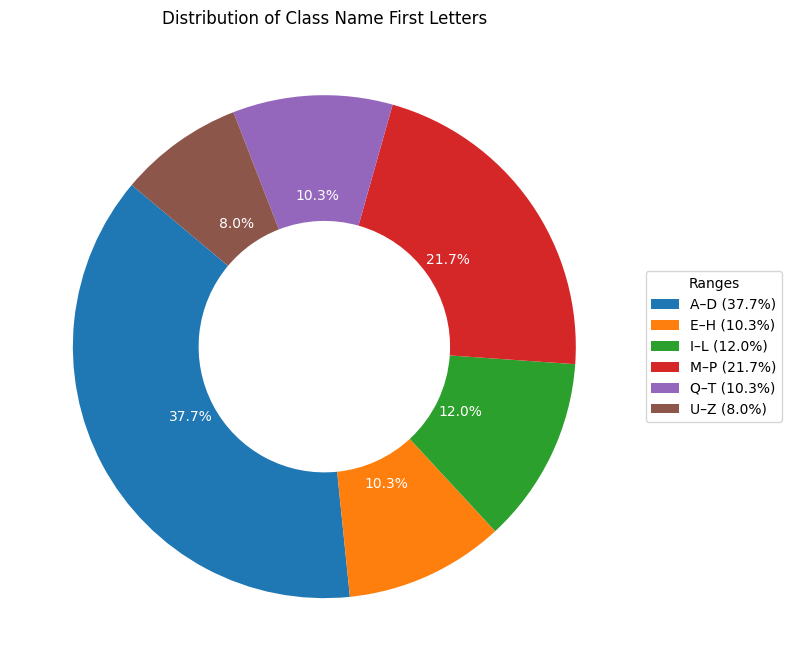

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')

# Extract the first letter of each class name
first_letters = df["Class"].str[0].str.upper()

# Define ranges
ranges = {
    "A–D": list("ABCD"),
    "E–H": list("EFGH"),
    "I–L": list("IJKL"),
    "M–P": list("MNOP"),
    "Q–T": list("QRST"),
    "U–Z": list("UVWXYZ"),
}

# Count values in each range
range_counts = {key: 0 for key in ranges}
for letter in first_letters:
    for key, chars in ranges.items():
        if letter in chars:
            range_counts[key] += 1
            break

# Prepare data for plotting
labels = list(range_counts.keys())
sizes = list(range_counts.values())

# Plotting the pie chart with percentages in a legend
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
wedges, texts, autotexts = ax.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.5),
    textprops=dict(color="white")
)

# Add legend with percentage labels
ax.legend(
    wedges,
    [f"{label} ({size / sum(sizes) * 100:.1f}%)" for label, size in zip(labels, sizes)],
    title="Ranges",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.set_facecolor('white')

ax.set_title("Distribution of Class Name First Letters")
plt.tight_layout()
plt.show()

## Ridiculous MLP for Amazon Reviews